# Problem Framing 

The goal of this notebook is to develop and test different strategies of data imputation. We're gonna be using both supervised and unsupervised methods, and both traditional Machine Learning algorithms and state-of-the-art deep learning solutions.
The discriminative ML methods we're gonna be using are:
- KNN Imputer
- Iterative Imputer

And the DL methods include:
- Iterative Multi-layer Perceptron (MLP) Imputer
- Auto-encoder Imputer
- Generative Adversarial Network (GAN) Imputer

# Selecting a performance measure

In this notebook, we're working on the diabetes dataset, which includes numerical attributes only. A good performance measure would be the `root mean squared error` (RMSE) averaged over all the predicted columns.


# Download the data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mathchi/diabetes-data-set")

print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

## Take a quick look at the data

In [ ]:
import pandas as pd

diabetes = pd.read_csv("diabetes.csv")
diabetes.head()

: 

In [4]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We have 768 instances and 8 numerical attributes, the target column is categorical but has been ordinally encoded, so we can safely use it as continuous variable. <br>
None of the instances have missing values, so we will have to introduce missing data manually. We will take of that later.

In [5]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


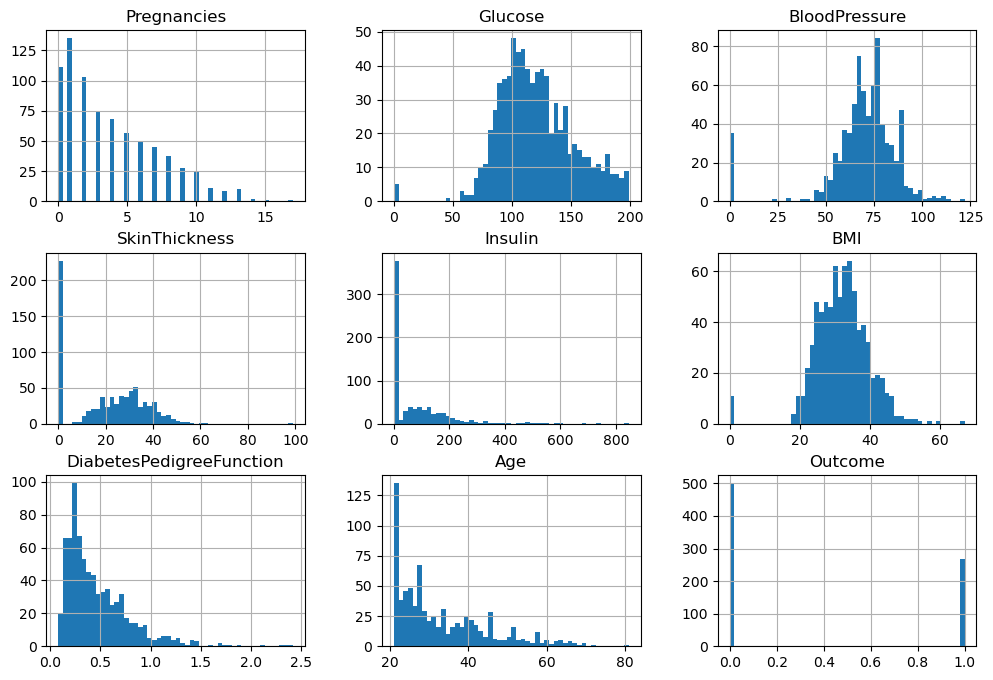

In [6]:
import matplotlib.pyplot as plt

diabetes.hist(bins=50, figsize=(12,8))
plt.show()

The first thing we can observe is the fact that many histograms are skewed right: Most data points are clustered toward the left side of the distribution, with a long tail on the right. They extend much farther to the right of the median than to the left, the mean is typically greater than the median. This may make it a bit harder for some machine learning algorithms to detect patterns. We will transform these attributes later to have more symmetrical and bell-shaped distributions. <br>
Another thing worth mentioning is that these attributes have very different scales. Most machine learning algorithms prefer attributes to have the same scales, e.g. neural networks tend to perform better with attributes with values ranging from -1 to 1.

# Create a Test set

Before transforming the data, it only seems logical to split the data into training and test splits. But before doing that, we're gonna have to introduce some missing data given the goal of this work.

In [8]:
import numpy as np

def introduceMissingValues(df, column_name, ratio):
    column = df[column_name].copy()
    num_missing_values = int(len(column) * ratio)
    random_indexes = np.random.choice(column.index, size=num_missing_values, replace=False)
    df.loc[random_indexes, column_name] = np.nan

In [9]:
introduceMissingValues(diabetes, "Insulin", ratio=0.1)
introduceMissingValues(diabetes, "Glucose", ratio=0.1)
introduceMissingValues(diabetes, "BloodPressure", ratio=0.1)

diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   692 non-null    float64
 2   BloodPressure             692 non-null    float64
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   692 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 54.1 KB


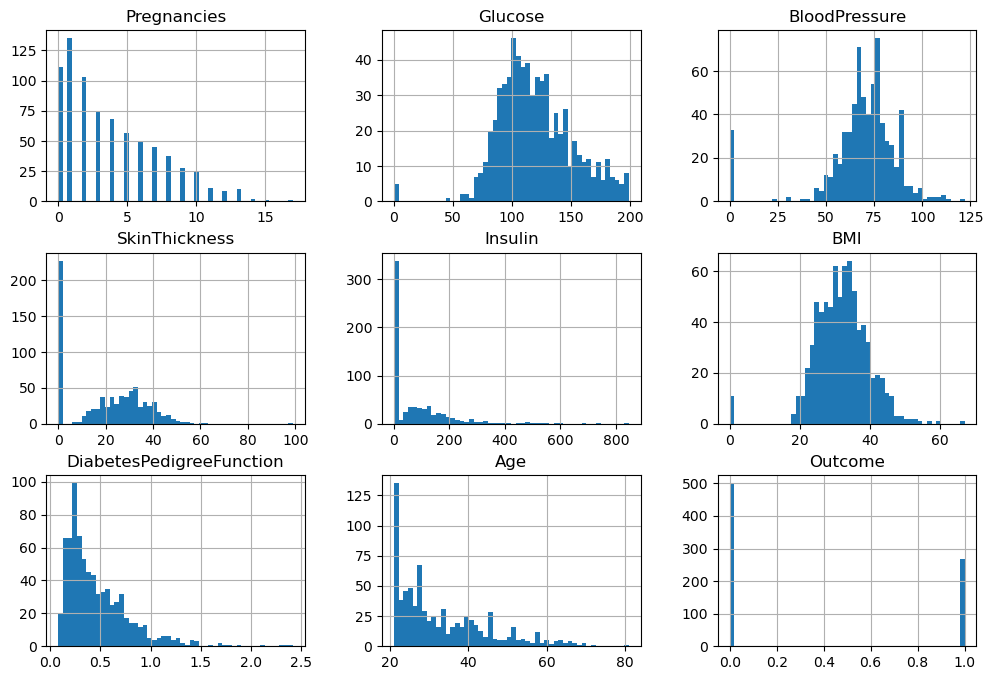

In [11]:
diabetes.hist(bins=50, figsize=(12,8))
plt.show()

To split the dataset into training and test sets, using random sampling methods is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not you run the risk of introducing significant sampling bias.
To get a better estimation of the generalization error, the test set has to be representative of the population. For that reason we're gonna sample a test set stratified on the age categories in the dataset.

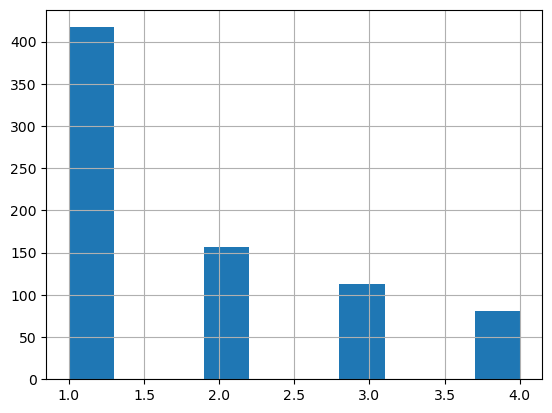

In [12]:
diabetes["Age_cat"] = pd.cut(diabetes["Age"],
                            bins=[20, 30, 40, 50, np.inf],
                            labels=[1, 2, 3, 4])

diabetes.Age_cat.hist()
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(diabetes, test_size=0.1, stratify=diabetes["Age_cat"], random_state=42)

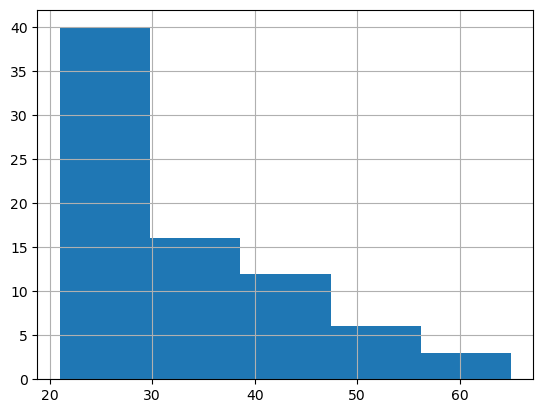

In [14]:
test_set["Age"].hist(bins=5)
plt.show()

In [15]:
# Drop Age_cat column because we won't use it again
for set_ in (train_set, test_set):
    set_.drop("Age_cat", axis=1, inplace=True)

# Look for correlations

Since the dataset isn't too large, you can easily compute Person's r coefficient (standard correlation coefficient) between every pair of attributes

In [16]:
# Make a copy of the original training set we can revert to afterwards
diabetes = train_set.copy()

In [17]:
corr_matrix = diabetes.corr()
corr_matrix

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.114879,0.157191,-0.110236,-0.063228,-0.013255,-0.055854,0.547493,0.197231
Glucose,0.114879,1.000000,0.162821,0.016652,0.316668,0.222662,0.128050,0.249630,0.462456
BloodPressure,0.157191,0.162821,1.000000,0.232747,0.092477,0.290213,0.036585,0.257682,0.067875
SkinThickness,-0.110236,0.016652,0.232747,1.000000,0.446221,0.382308,0.176826,-0.127228,0.056837
Insulin,-0.063228,0.316668,0.092477,0.446221,1.000000,0.205935,0.180458,-0.013434,0.155610
BMI,-0.013255,0.222662,0.290213,0.382308,0.205935,1.000000,0.125896,0.033539,0.291834
DiabetesPedigreeFunction,-0.055854,0.128050,0.036585,0.176826,0.180458,0.125896,1.000000,0.026605,0.166563
Age,0.547493,0.249630,0.257682,-0.127228,-0.013434,0.033539,0.026605,1.000000,0.220255
Outcome,0.197231,0.462456,0.067875,0.056837,0.155610,0.291834,0.166563,0.220255,1.000000


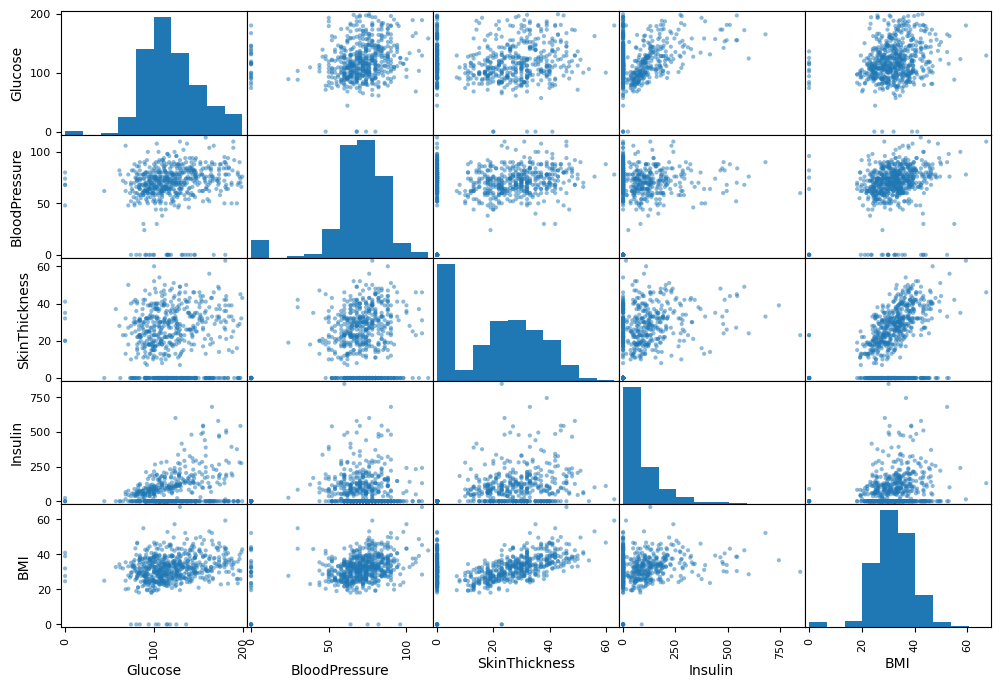

In [18]:
from pandas.plotting import scatter_matrix

attributes = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

scatter_matrix(diabetes[attributes], figsize=(12, 8))
plt.show()

# Prepare Data for ML algorithms

We observed that the attributes have very different scales and some have a long tail. It's about time we took care of that! <br>
There are several ways to scale data, the most famous methods include min-max scaling (Normalization) & Stdandardization (Z-score Normalization). When a feature's distribution has a heavy tail, both these methods will squash most values into a small range. So before scaling the features, we need to shrink the heavy tails, and if possible make the distribution roughly symmetrical.

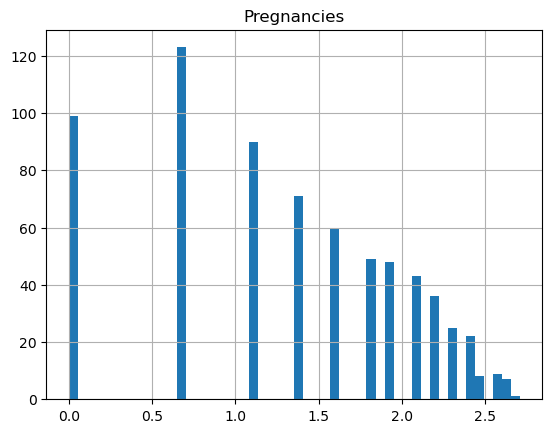

In [19]:
import matplotlib.pyplot as plt
# TODO : Measure information loss after transformation
pregnancies_transformed = np.log1p(diabetes[["Pregnancies"]])
pregnancies_transformed.hist(bins=50)
plt.show()

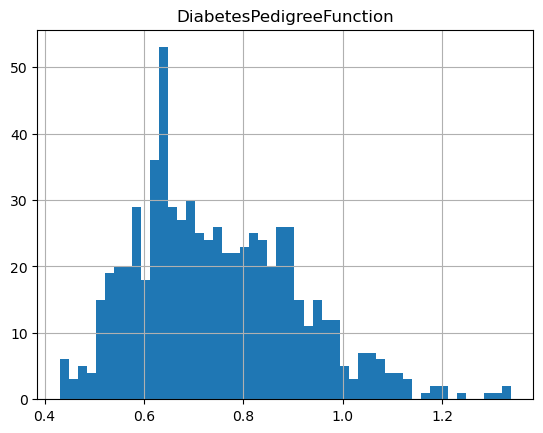

In [20]:
# TODO : Measure information loss after transformation
diabetesPedigreeFunction_transformed = np.power(diabetes[["DiabetesPedigreeFunction"]], 0.33)
diabetesPedigreeFunction_transformed.hist(bins=50)
plt.show()

<Axes: ylabel='Count'>

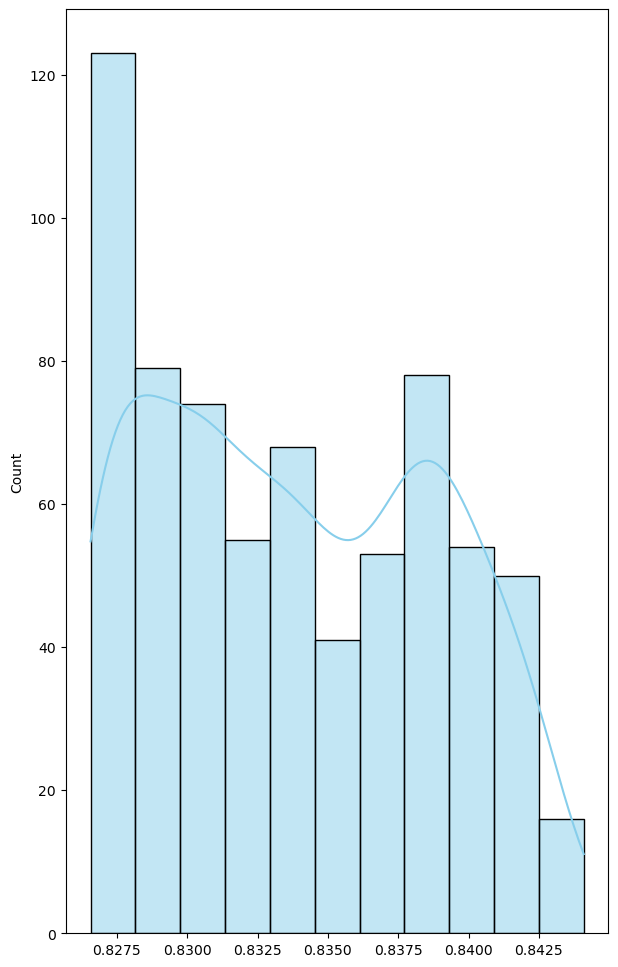

In [21]:
# TODO : Measure information loss after transformation
from scipy.stats import boxcox
import seaborn as sns

age_transformed, _ = boxcox(diabetes.Age + 1)
plt.figure(figsize=(7, 12))
sns.histplot(age_transformed, kde=True, color="skyblue")

In [22]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
diabetes_scaled = std_scaler.fit_transform(diabetes)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV


# Define the transformations for each column
transformers = [
    # Log1p transformation for "Pregnancies"
    ("pregnancies_log", FunctionTransformer(np.log1p), ["Pregnancies"]),
    
    # Cube root transformation for "DiabetesPedigreeFunction"
    ("diabetes_pedigree_cbrt", FunctionTransformer(lambda x: np.power(x, 0.33)), ["DiabetesPedigreeFunction"]),
    
    # Box-Cox transformation for "Age"
    ("age_boxcox", PowerTransformer(method='box-cox'), ["Age"]),  # Box-Cox requires strictly positive values.
]

# Combine all transformations
column_transformer = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough'  # Keep other columns as they are
)

# Custom function to wrap IterativeImputer and return a DataFrame
# def impute_and_return_dataframe(X):
    # imputer = IterativeImputer(estimator=DecisionTreeRegressor(), max_iter=10, random_state=0)
    # imputed_data = imputer.fit_transform(X)
    # return pd.DataFrame(imputed_data, columns=X.columns)

# Define the full preprocessing pipeline
preprocessing_pipeline = Pipeline([
    # Imputation step (custom transformer to retain DataFrame structure)
    # ("imputer", FunctionTransformer(impute_and_return_dataframe)),
    # Transformation step
    ("column_transform", column_transformer),
    # Scaling step
    ("scaler", StandardScaler())
]) 


# Apply RandomizedSearchCV to find the best hyperparameters

param_distributions = {
    'imputer__max_iter': [5, 10, 15],
    'imputer__estimator__max_depth': [5, 10, 15],
    'imputer__estimator__min_samples_split': [2, 5, 10],
    'imputer__estimator__min_samples_leaf': [1, 2, 4]
}

# Define the RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Create a RandomizedSearchCV object
search = RandomizedSearchCV(
    i_pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    scoring=rmse_scorer, 
    n_jobs=-1, 
    cv=5, 
    random_state=0
)

# Fit the RandomizedSearchCV object to the data
search.fit(diabetes.drop("Outcome", axis=1), diabetes["Outcome"])

# Get the best hyperparameters

search.best_params_

Index(['Pregnancies', 'DiabetesPedigreeFunction', 'Age', 'OtherFeature'], dtype='object')
   Pregnancies  DiabetesPedigreeFunction       Age  OtherFeature
0    -1.176145                 -1.549839 -1.413591     -1.543487
1    -1.176145                 -0.764144 -0.726095     -0.685994
2     0.329074                  0.575860 -0.081948      0.171499
3     0.813646                  0.575860  1.110817      1.028992
4     1.209570                  1.162262  1.110817      1.028992


In [ ]:
# Get best model
best_model = search.best_estimator_

In [ ]:
# transform the test set
test_set_transformed = best_model.transform(test_set)